<a href="https://colab.research.google.com/github/ma2sevich222/study_projects/blob/main/Time%20series._Forecasting_Lukoil_shares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import utils 
import numpy as np 
from keras.optimizers import Adam 
from keras.models import Sequential, Model 
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, CuDNNLSTM,LSTM, MaxPooling1D
from google.colab import files 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 


%matplotlib inline

In [ ]:
files.upload()
!ls

Saving 18_19.csv to 18_19.csv
Saving 16_17.csv to 16_17.csv
16_17.csv  18_19.csv  sample_data


In [ ]:
!ls

16_17.csv  18_19.csv  sample_data


In [ ]:
base_data = pd.read_csv('18_19.csv')

In [ ]:
print(base_data.head())

                 DATE;TIME;OPEN;MAX;MIN;CLOSE;VOLUME
0       03.01.2018;10:00:00;3341;3356;3340;3355;6088
1       03.01.2018;10:01:00;3355;3359;3353;3353;1624
2  03.01.2018;10:02:00;3351.5;3357.5;3351.5;3357....
3   03.01.2018;10:03:00;3354.5;3360;3354.5;3358;3034
4     03.01.2018;10:04:00;3358;3360;3351.5;3360;1427


In [ ]:
txt = base_data.values[0]
print(txt)

['03.01.2018;10:00:00;3341;3356;3340;3355;6088']


In [ ]:

def strList2Float(lst):
  return [float(i) for i in lst]


def getData(df):
  values = df.values 
  data = []
  
  
  for v in values:
    currStr = v[0].split(sep=";") 
    currStr = currStr[2:] 
    currStr = strList2Float(currStr) 
    data.append(currStr) 
  
  return data


def getDataFromFile(fileName):
  df = pd.read_csv(fileName) 
  return getData(df)

In [ ]:
data16_17 = getDataFromFile('16_17.csv')
data18_19 = getDataFromFile('18_19.csv')

In [ ]:
d = data18_19
print(len(d)) 
print(len(d[0])) 
print(d[0]) 

217947
5
[3341.0, 3356.0, 3340.0, 3355.0, 6088.0]


In [ ]:
data = data16_17.copy() 
data.extend(data18_19)
data = np.array(data)

In [ ]:
print(len(data16_17)) 
print(len(data18_19)) 
print(len(data))

263925
217947
481872


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


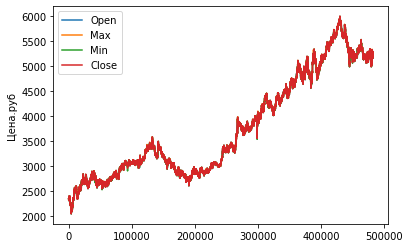

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


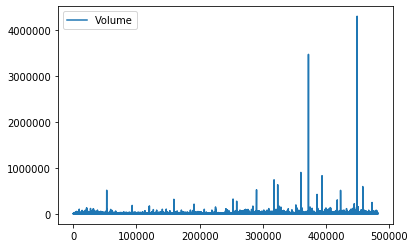

In [ ]:
start = 0 
step = data.shape[0] 


chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']


for i in range(4):
  
  plt.plot(data[start:start+step,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()


plt.plot(data[start:start+step,4], label="Volume")
plt.legend()
plt.show()

**Функция загрузки данных**

In [ ]:
#Функция "раскусывания" данных для временных рядов
#data - данные
#xLen - размер фрейма, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее
#если 0 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#returnFlatten - делать ли одномерный вектор на выходе для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производную
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):
  
  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (xNormalization == 0):
    xScaler = StandardScaler()
  else:
    xScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  xData = data[:,xChannels]
  #Обучаем нормировщик
  xScaler.fit(xData)
  #Нормируем данные
  xData = xScaler.transform(xData)

  #Выбираем тип нормализации y
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (yNormalization == 0):
    yScaler = StandardScaler()
  else:
    yScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  yData = data[:,yChannels]
  #Обучаем нормировщик
  yScaler.fit(yData)
  #Нормируем данные
  yData = yScaler.transform(yData)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i+xLen, :] for i in range(xData.shape[0]-xLen-1-stepsForward)])
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 0):
    yTrain = np.array([yData[i+xLen:i+xLen+stepsForward, :] for i in range(yData.shape[0]-xLen-1-stepsForward)])
  else:
    yTrain = np.array([yData[i+xLen+stepsForward, :] for i in range(yData.shape[0]-xLen-1-stepsForward)])

  #Делаем reshape y в зависимости от того
  #Прогнозируем на 1 шаг вперёдили на несколько
  if (stepsForward == 0):
    if ((len(yChannels) == 1)):
      yTrain = yTrain.reshape(yTrain.shape[0], 1)
  else:
      yTrain = yTrain.reshape(yTrain.shape[0], stepsForward)
  
  #Расчитыываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [ ]:
##Формируем параметры загрузки данных
xLen = 300
stepsForward = 0
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 10000
returnFlatten = 0 #Возвращаем двумерные данные для свёртки
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(471269, 300, 5)
(471269, 1)
(10000, 300, 5)
(10000, 1)


Train on 471269 samples, validate on 10000 samples
Epoch 1/10
471269/471269 [==============================] - 150s 319us/step - loss: 0.0125 - val_loss: 0.0018
Epoch 2/10
471269/471269 [==============================] - 149s 315us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 3/10
471269/471269 [==============================] - 150s 319us/step - loss: 0.0026 - val_loss: 9.3650e-04
Epoch 4/10
471269/471269 [==============================] - 150s 317us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 5/10
471269/471269 [==============================] - 152s 322us/step - loss: 0.0014 - val_loss: 6.4201e-04
Epoch 6/10
471269/471269 [==============================] - 152s 322us/step - loss: 0.0012 - val_loss: 5.4484e-04
Epoch 7/10
471269/471269 [==============================] - 150s 319us/step - loss: 0.0010 - val_loss: 4.9367e-04
Epoch 8/10
471269/471269 [==============================] - 149s 315us/step - loss: 7.0563e-04 - val_loss: 4.0737e-04
Epoch 9/10
471269/471269 [===================

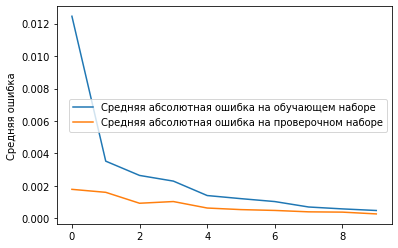

In [ ]:
model = Sequential()
model.add(Conv1D(50, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(50, 5,activation="linear"))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
#model.add(Dense(50, activation="linear"))
model.add(Dense(yTrain.shape[1], activation="linear"))

model.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=10, 
                    batch_size=150, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
#Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  #Рассчитываем основные показатели
  ma = a.mean() #Среднее значение первого вектора
  mb = b.mean() #Среднее значение второго вектора
  mab = (a*b).mean() #Среднее значение произведения векторов
  sa = a.std() #Среднеквадратичное отклонение первого вектора
  sb = b.std() #Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисуем корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    #Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      #Получаем сигнал, смещённый на i шагов назад
      #predVal[i:, ch]
      #Сравниваем его с верными ответами, без смещения назад
      #yValUnscaled[:yLen-i,ch]
      #Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    #Отображаем график коррелций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
currModel = model 
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler) 

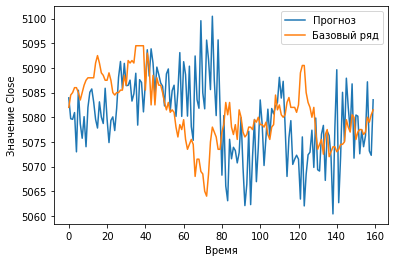

In [ ]:
showPredict(0, 160, 0, predVal, yValUnscaled)

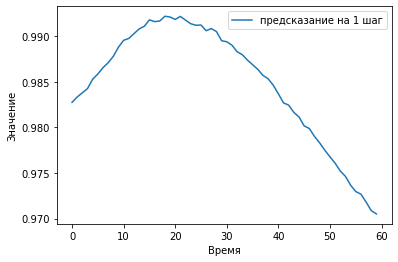

In [ ]:
showCorr([0], 60, predVal, yValUnscaled)

In [ ]:
xLen = 300 #Анализируем по 300 прошедшим точкам 
stepsForward = 0 #Предсказываем на 1 шаг вперёд
xChannels = range(data.shape[1]) #Используемвсе входные каналы
yChannels = [0] #Предказываем только open канал
xNormalization = 1 #1 - к отрезку [0;1]
yNormalization = 1 #1 - к отрезку [0;1]
valLen = 10000 #Используем 30.000 записей для проверки0
returnFlatten = 1 #Вернуть одномерные вечеторы
convertToDerivative = 0 #Не превращать в производную

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(471269, 1500)
(471269, 1)
(10000, 1500)
(10000, 1)


Train on 471269 samples, validate on 10000 samples
Epoch 1/10
471269/471269 [==============================] - 85s 181us/step - loss: 0.0013 - val_loss: 3.3323e-04
Epoch 2/10
471269/471269 [==============================] - 80s 170us/step - loss: 8.5698e-04 - val_loss: 8.1179e-06
Epoch 3/10
471269/471269 [==============================] - 80s 169us/step - loss: 6.3084e-04 - val_loss: 0.0055
Epoch 4/10
471269/471269 [==============================] - 80s 169us/step - loss: 2.9936e-04 - val_loss: 1.4161e-05
Epoch 5/10
471269/471269 [==============================] - 81s 172us/step - loss: 2.1142e-04 - val_loss: 1.5622e-05
Epoch 6/10
471269/471269 [==============================] - 77s 162us/step - loss: 1.3867e-04 - val_loss: 1.2362e-05
Epoch 7/10
471269/471269 [==============================] - 78s 166us/step - loss: 8.3621e-05 - val_loss: 0.0071
Epoch 8/10
471269/471269 [==============================] - 75s 160us/step - loss: 6.0248e-05 - val_loss: 1.6515e-05
Epoch 9/10
471269/471269 

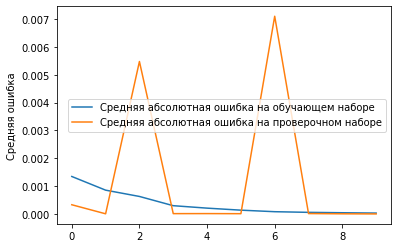

In [ ]:

model1 = Sequential()
model1.add(Dense(100, input_dim = xTrain.shape[1], activation="linear"))
model1.add(Dense(yTrain.shape[1], activation="linear"))


model1.compile(loss="mse", optimizer=Adam(lr=1e-4))


history = model1.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=20, 
                    verbose=1, 
                    validation_data=(xVal, yVal))


plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

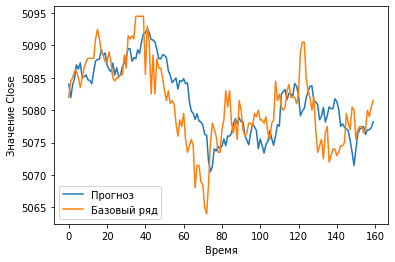

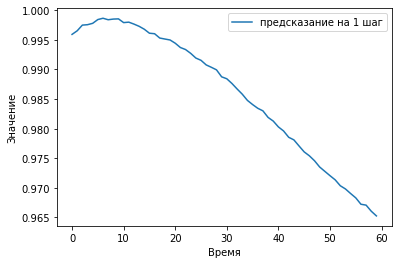

In [ ]:
currModel = model1 
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler) 
showPredict(0, 160, 0, predVal, yValUnscaled)
showCorr([0], 60, predVal, yValUnscaled)


Выводы Свертка(1 сверточный слой, макс пулинг,флатен и 2 полносвязных слоя) в изначальном вареанте показал себя лучше, чем полносвязная.Но запаздывала на 7 шагов. Решил продолжить с ней. При добаавлении еще одного свертоного слоя, график корреляции был ввиде колокола в вершиной на тридцатом шаге. Убрал дэнсе слой, вершина сметсилась на 20-й шаг. Возможно, если поработать с гипер параметрами, результаты будут лучше.